In [18]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import PorterStemmer
from datetime import datetime

def goodRating(row):
    return row >= 3

def avgSentiment(row, w_dict):
    s = 0
    tokens = row.split()
    for t in tokens:
         s += w_dict[t]
    return s/len(tokens)

def avgSentiment(row, w_dict):
    s = 0
    count = 0
    tokens = row.split()
    for t in tokens:
        try:
            s += w_dict[t]
            count += 1
        except:
            continue
    return s/count

def posWords(row, w_dict):
    numWords = 0
    tokens = row.split()
    for t in tokens:
        try: 
            if w_dict[t] > 0:
                numWords += 1
        except:
            continue
    return numWords

def negWords(row, w_dict):
    numWords = 0
    tokens = row.split()
    for t in tokens:
        try: 
            if w_dict[t] < 0:
                numWords += 1
        except:
            continue
    return numWords

def date_to_nth_day(date, format='%Y-%m-%d'):
    date = pd.to_datetime(date, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1

# Porter stemmer for text stemming
porter = PorterStemmer()

stop = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", 
        "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", 
        "she", "her", "hers", "herself", "it", "its", "itself", "they", 
        "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
        "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", 
        "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", 
        "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", 
        "for", "with", "about", "against", "between", "into", "through", "during", "before", 
        "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
        "over", "under", "again", "further", "then", "once", "here", "there", "when", 
        "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", 
        "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", 
        "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))


In [19]:
data = pd.read_csv("../data400_share/beer.csv")
data.drop('index',axis =1, inplace = True)
newCols = [col.split('/')[1] for col in data.columns]
data = pd.DataFrame(data.values, columns = newCols).drop(['beerId','brewerId'], axis = 1)
train=data
train.head()

,ABV,name,style,appearance,aroma,overall,palate,taste,text,timeStruct,timeUnix,ageInSeconds,birthdayRaw,birthdayUnix,gender,profileName
0,5,Chiostro,Herbed / Spiced Beer,4,4,4,4,4,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,11,Bearded Pat's Barleywine,American Barleywine,4,3.5,3.5,3.5,3,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,4.7,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,4.4,Pilsner Urquell,Czech Pilsener,3,3,2.5,3,3,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.20983e+09,"Aug 10, 1976",2.08508e+08,Male,molegar76
4,4.4,Black Sheep Ale (Special),English Pale Ale,4,3,3,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


In [20]:
train['sumReviews'] = train['appearance'] + train['aroma'] + train['overall'] + train['palate'] + train['taste']
sumMean = train['sumReviews'].mean()
train['sumReviews'] =  train['sumReviews'].astype(float)
userSumMean = train.groupby(['profileName'])['sumReviews'].mean().reset_index()
userSumMean['userBias'] = userSumMean['sumReviews'] - sumMean
train = train.merge(userSumMean, left_on='profileName', right_on='profileName', how='left')
train = train.drop(['sumReviews_y','sumReviews_x'],axis=1)

In [21]:

# Additional featureW
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
train['char_count'] = train['text'].str.len() ## this also includes spaces
train['avg_word_len'] = train['text'].apply(lambda x: avg_word(str(x)))
train['stopwords'] = train['text'].apply(lambda x: len([x for x in str(x).split() if x in stop]))
train['questions'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '?' in str(x)]))
train['ellipses'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '...' in str(x)]))
train['exclamations'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '!' in str(x)]))
train['plus'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '+' in str(x)]))
train['star'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '*' in str(x)]))
train['numerics'] = train['text'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
train['upper'] = train['text'].str.findall(r'[A-Z]').str.len()
train["age_years"] = (train['ageInSeconds']/31536000.0)#.apply(np.floor)

In [22]:
train["timeStruct"] = train["timeStruct"].apply(lambda x: dict(eval(x)))
beerTimeDic = train["timeStruct"]

holidays =[
  '2012-01-02',
  '2012-01-16',
  '2012-02-20',
  '2012-05-28',
  '2012-07-04',
  '2012-09-03',
  '2012-10-08',
  '2012-11-12',
  '2012-11-22',
  '2012-12-25']

ydayHoliday = []
for date in holidays:
    ydayHoliday.append(date_to_nth_day(date))
    
weekHoliday = []
for day in ydayHoliday:
    temp = list(range(day-3,day+3))
    temp = [x for x in temp if(x>0 & x<367)]
    for x in temp:
        weekHoliday.append(x)
        
train["isHolidayWeek"] = train["timeStruct"].apply(lambda x: 1 if x['yday'] in weekHoliday else 0)
train["isWeekend"] = train["timeStruct"].apply(lambda x: 1 if x['wday'] in [4,5,6] else 0)

In [23]:
# Convert reviews to lower case
train['text'] = train['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

# Remove punctuation characters from  text review
train['text'] = train['text'].str.replace('[^\w\s]','')
# Remove stop words
train['text'] = train['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

# Stem words
train['text'] = train['text'].apply((lambda x: " ".join(porter.stem(x) for x in str(x).split())))

# Remove least frequent words
l_freq = pd.Series(' '.join(train['text']).split()).value_counts()[-10:]
l_freq = list(l_freq.index)
train['text'] = train['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in l_freq))

# Label beer ratings as positive or negative
train['target'] = train['overall'].apply(goodRating)
train.sort_values(by = 'overall', ascending = False, inplace = True)

In [24]:
text_train = train['text'].values
target = train['target'].values

In [25]:
#Vectorize words from beer rating text
cv = CountVectorizer(binary=True)
cv.fit(text_train)
X = cv.transform(text_train)
#X_test = cv.transform(reviews_test_clean)


In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

c_values = np.linspace(.01,1,100)
accuracy = []
for c in c_values:
    lr = LogisticRegression(C=c, solver='liblinear')
    lr.fit(X_train, y_train)
    
    #print ("Accuracy for C=%s: %s" 
          # % (c, accuracy_score(y_val, lr.predict(X_val))))
    accuracy.append(accuracy_score(y_val, lr.predict(X_val)))
    

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Best C Value: 0.09


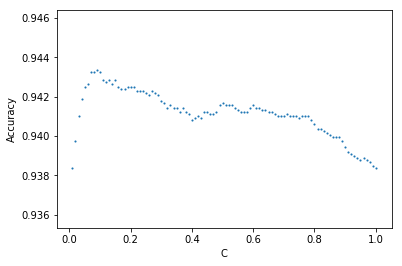

In [27]:
# Optimize the C hyperparameter for regularization 
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(c_values, accuracy, s = 1.2)
plt.ylabel('Accuracy')
plt.xlabel('C')
best_c = c_values[accuracy.index(max(accuracy))]
print('Best C Value:', best_c)

In [28]:
final_model = LogisticRegression(C = best_c, solver = 'liblinear')
final_model.fit(X, target)

LogisticRegression(C=0.089999999999999997, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [29]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('easi', 1.1719874134635073)
('awesom', 0.75278095350308971)
('smooth', 0.73446891507511525)
('tasti', 0.71961684670303983)
('rye', 0.6801721932874395)


In [30]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('drain', -1.072984516223815)
('drainpour', -0.88525673107611524)
('worst', -0.82315189352896811)
('aw', -0.80477925089616498)
('chemic', -0.78478930639831357)


In [31]:
train['avg_sent'] = train['text'].apply(avgSentiment, args = (feature_to_coef,))
train['#pos_words'] = train['text'].apply(posWords, args = (feature_to_coef,))
train['#neg_words'] = train['text'].apply(negWords, args = (feature_to_coef,))
train['#pos/#neg'] = train['#pos_words']/train['#neg_words']
# Some values turn to infinite due to 0 divison, its fixed below
mask = train['#pos/#neg'] != np.inf
# Make values that infinite equal to the # pos words
train.loc[~mask, '#pos/#neg' ] = train.loc[~mask, '#pos_words']


In [43]:
open_beer = pd.read_csv('open-beer-database.csv', sep = ';').rename(columns = {'Name':'name'})
open_beer = open_beer[['name','Country']]
open_beer.drop_duplicates(inplace = True)
one_hot = pd.get_dummies(open_beer['Country'])
open_beer.drop('Country', axis = 1, inplace = True)
open_beer = open_beer.join(one_hot)
beer_names = list(set(open_beer['name'].values))

# Compress one hot encoding to get one beer and all locations into one row
beer_locs = []
for beer in beer_names:
    cur_beer = open_beer[open_beer['name'] == beer]
    t = np.zeros(one_hot.shape[1])
    for row in cur_beer.iterrows():
        index, data = row
        t = np.add( t, np.array(data)[1:])
    beer_locs.append(t)   
final_hot = pd.DataFrame.from_items(zip(one_hot.columns, np.array(beer_locs).T))
final_hot['name'] = beer_names

merged = pd.merge(train, final_hot, on = 'name', how = 'left')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


In [49]:
merged.to_csv('train.csv',index = False)